# Exercise 5

In [1]:
import torch
import torch.nn as nn

In this exercise, we will use the CIFAR10 dataset. It consists of 32x32 color images of 10 classes (e.g. airplane, bird, frog, ..., see below). The task is to predict the correct class, given the image.

In [2]:
from torchvision.datasets import CIFAR10

train_data = CIFAR10('./cifar', download=True, train=True)
val_data = CIFAR10('./cifar', download=True, train=False)

Extracting ./cifar/cifar-10-python.tar.gz to ./cifar
Files already downloaded and verified


We can inspect the layout of the dataset:

In [3]:
print("len(train_data):", len(train_data))
print("len(val_data):", len(val_data))
print()
first_sample = train_data[0]
print("type(first_sample):", type(first_sample))
print("len(first_sample):", len(first_sample))
print("type(first_sample[0]):", type(first_sample[0]))
print("type(first_sample[1]):", type(first_sample[1]))
print()

image = first_sample[0]
label = first_sample[1]

print("Image size:", image.size)
print("Label:", label)

len(train_data): 50000
len(val_data): 10000

type(first_sample): <class 'tuple'>
len(first_sample): 2
type(first_sample[0]): <class 'PIL.Image.Image'>
type(first_sample[1]): <class 'int'>

Image size: (32, 32)
Label: 6


According to [the website](https://www.cs.toronto.edu/~kriz/cifar.html), the classes are:

In [4]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Visualizing the data is always a good idea:

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

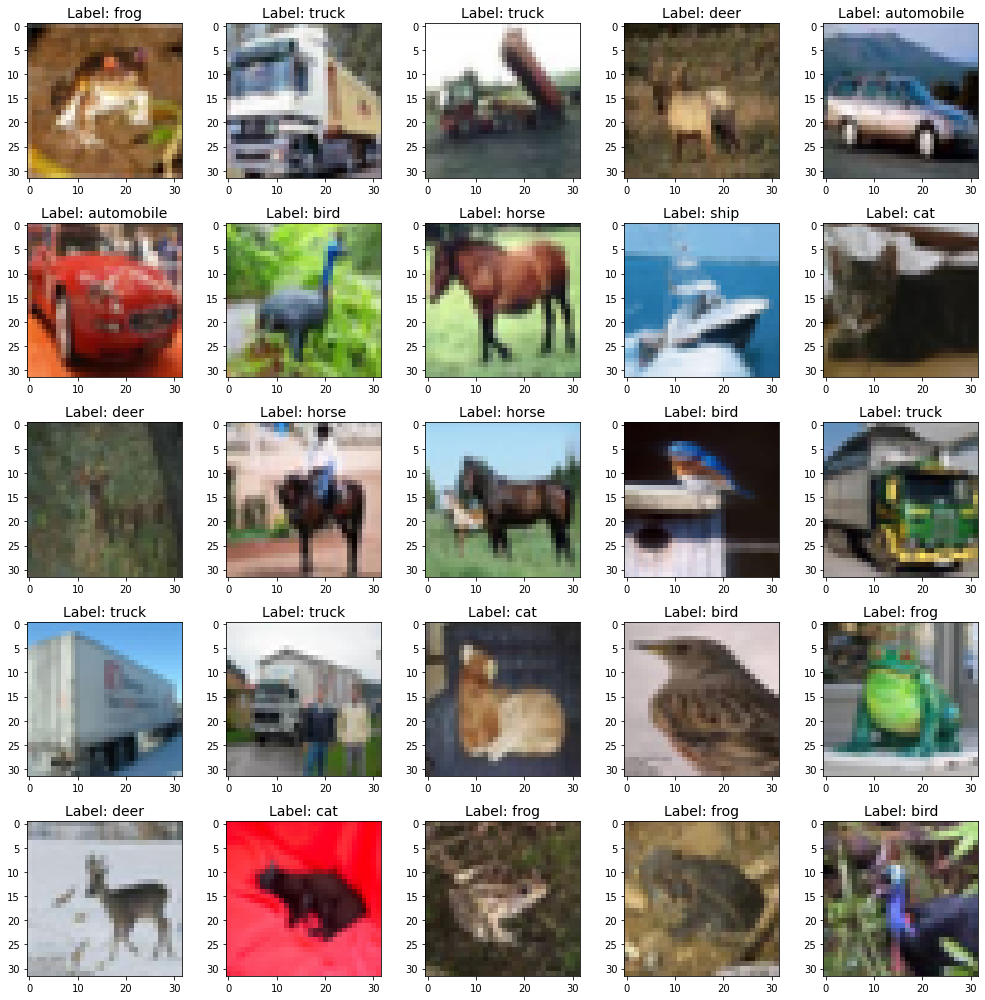

In [6]:
fig, axes = plt.subplots(5, 5, figsize=(14, 14))
for i in range(25):
    image, label = train_data[i]
    ax = axes[i//5, i%5]
    ax.imshow(image)
    ax.set_title(f"Label: {classes[label]}", fontdict={"fontsize": 14})
plt.tight_layout()
plt.show()

## Augmentation

On the training dataset, we will use some data augmentation: RandomHorizontalFlip, RandomCrop and Normalize. Flipping the image horizontally should still allow the network to guess the correct class, as e.g. a frog mirrored left-to-right is still a frog. RandomCrop will in this case yield 32x32 crops of the input image, and add padding on the sides (see visualization below). This augmentation preserves the main part of the image, but moves the image content around and adds some padding on the sides. This should still allow the network to guess the correct class, as we do not crop out too much of the image. One could also use other augmentation methods such as RandomRotation, but these are the augmentation methods described in the [original ResNet paper](https://arxiv.org/pdf/1512.03385.pdf).

This augmentation can artificially enlarge the number of training examples we have in our dataset and help to prevent overfitting.

In [7]:
from torchvision.transforms import ToTensor, Compose, Normalize, RandomHorizontalFlip, RandomCrop
from torch.utils.data import DataLoader

# Image transforms
normalize_mean = [0.485, 0.456, 0.406]
normalize_std = [0.229, 0.224, 0.225]
normalize = Normalize(mean=normalize_mean, std=normalize_std)

train_transform = Compose([
    RandomHorizontalFlip(),
    RandomCrop(32, 4),
    ToTensor(),
    normalize
])
val_transform = Compose([
    ToTensor(),
    normalize
])

train_data_torch = CIFAR10('./cifar', download=True, train=True, transform=train_transform)
val_data_torch = CIFAR10('./cifar', download=True, train=False, transform=val_transform)

Files already downloaded and verified
Files already downloaded and verified


Instead of writing our own `Loader` class, as we did in the previous exercises, we will now use the pytorch [DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) class for this. It takes a dataset that must be either iterable or indexable and have a length (`__len__`). The Dataloader can be iterated with `for batch in dataloader: ...`, as we did in the previous exercises. The DataLoader class has some improvements to our own `Loader` class, e.g. it can perform the image augmentation on dedicated worker processes, speeding up the training heavily if the augmentation is slow.

In [8]:
BATCH_SIZE = 128
train_loader = DataLoader(train_data_torch, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_data_torch, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

We can have a look at a few training images, to see what the augmentation does to our images:

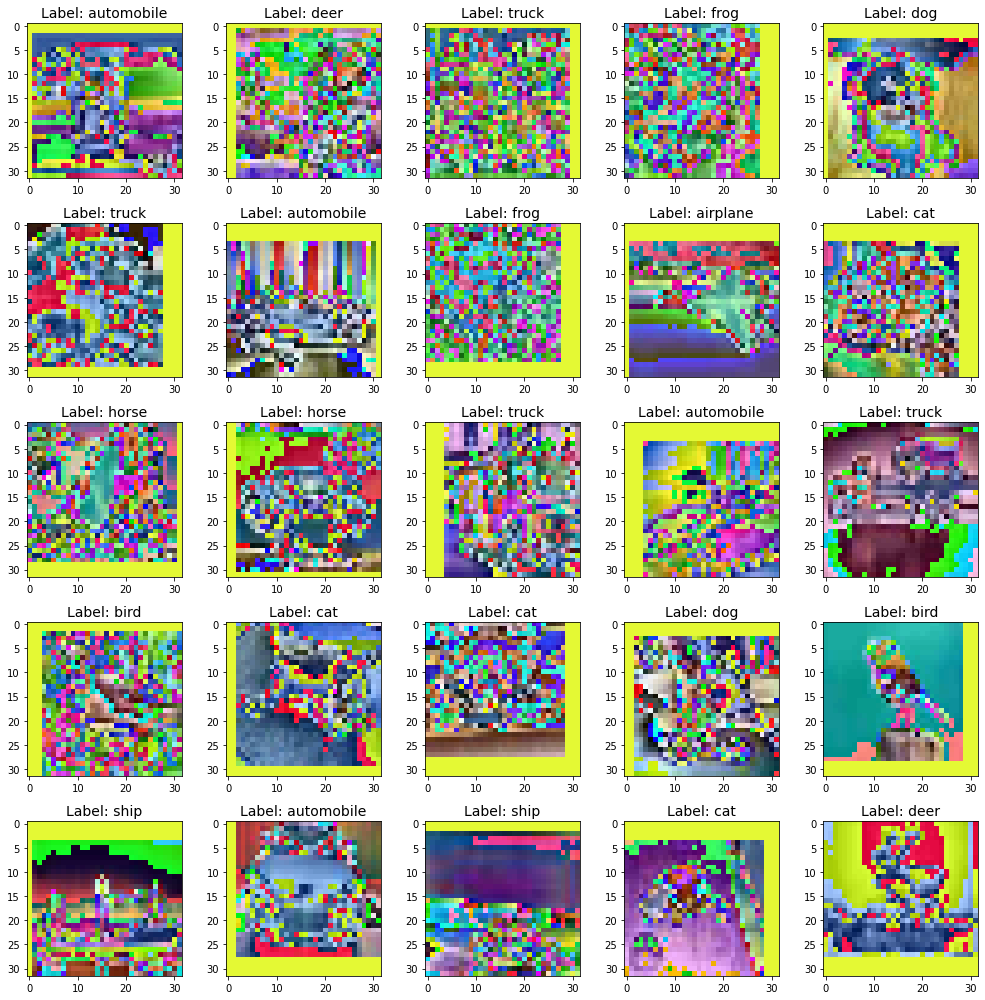

In [9]:
from torchvision.transforms.functional import to_pil_image

fig, axes = plt.subplots(5, 5, figsize=(14, 14))
first_batch = next(train_loader.__iter__())
for i in range(25):
    image, label = first_batch[0][i], first_batch[1][i]
    ax = axes[i//5, i%5]
    # transform tensor back to a PIL image
    image = to_pil_image(image.cpu())
    ax.imshow(image)
    ax.set_title(f"Label: {classes[label]}", fontdict={"fontsize": 14})
plt.tight_layout()
plt.show()

Ok, that looks a bit strange. That's because we did not undo the normalization of the image. But at least now you know how our images look to the neural network ;-)

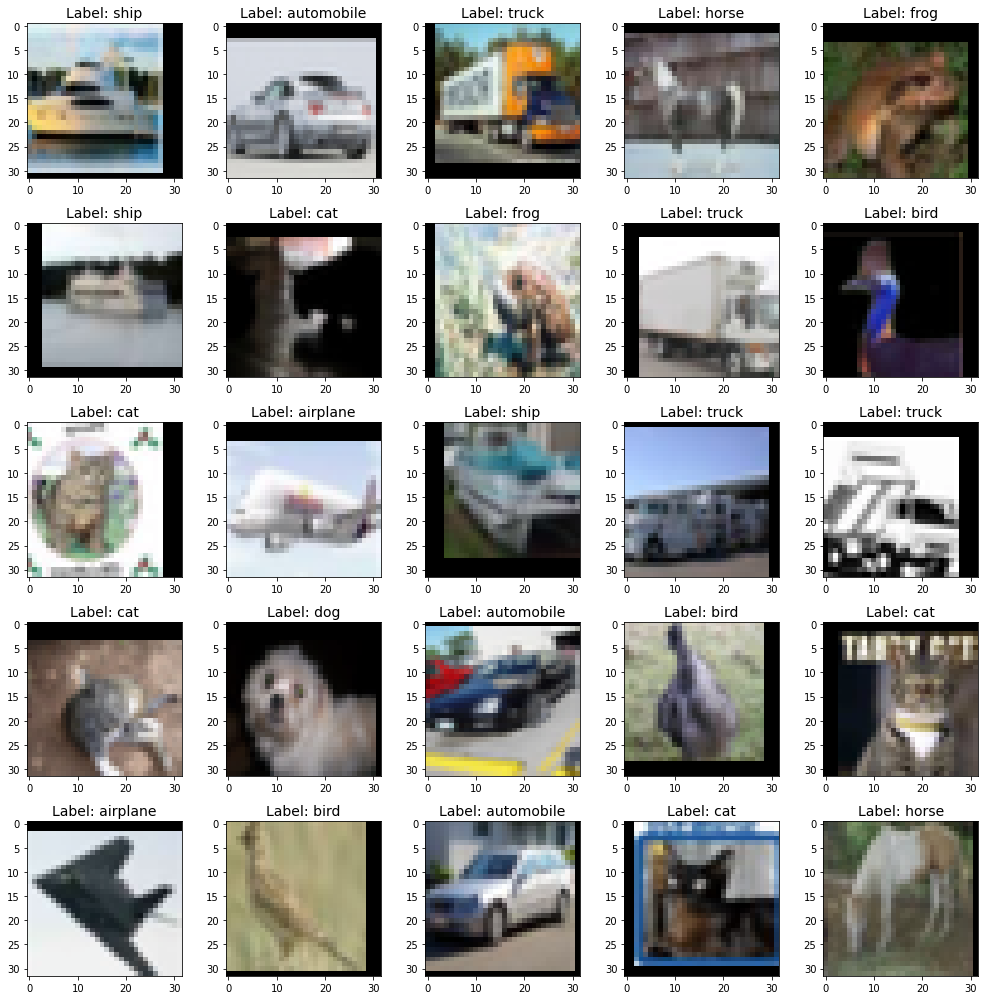

In [10]:
from torchvision.transforms.functional import to_pil_image

fig, axes = plt.subplots(5, 5, figsize=(14, 14))
first_batch = next(train_loader.__iter__())
for i in range(25):
    image, label = first_batch[0][i], first_batch[1][i]
    ax = axes[i//5, i%5]
    # undo image normalization
    for channel in range(3):
        image[channel] *= normalize_std[channel]
        image[channel] += normalize_mean[channel]
    # transform tensor back to a PIL image
    image = to_pil_image(image.cpu())
    ax.imshow(image)
    ax.set_title(f"Label: {classes[label]}", fontdict={"fontsize": 14})
plt.tight_layout()
plt.show()

## Training

Ok, now on to the actual training. We instantiate the network and the optimizer:

In [11]:
from torchvision.models import resnet18
model = resnet18(num_classes=10, pretrained=False)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
LR = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=LR, weight_decay=0.0001, momentum=0.9)

In [12]:
train_losses = []
val_losses = []
train_accuracy = []
val_accuracy = []

The training loop is very similar to the last exercises. One difference is the addition of a `train_batch_epoch_limit` variable. This allows us to decrease the number of batches that we process per training epoch. If one does not have a GPU, iterating the whole 60000 images of the training set takes quite some time. If we decrease the number of batches per epoch, we can perform shorter epochs and thus log the training accuracy more frequently.

In [13]:
from torch.nn.functional import cross_entropy
import numpy as np
import tqdm

NUM_EPOCHS = 20
NUM_CLASSES = 10

train_batch_epoch_limit = 100
val_batch_epoch_limit = 100

for epoch in range(NUM_EPOCHS):
    # perform training followed by validation
    for mode, loader, batch_epoch_limit in [
        ("train", train_loader, train_batch_epoch_limit),
        ("val", val_loader, val_batch_epoch_limit)
    ]:
        # progressbar setup
        num_batches = min(len(loader), batch_epoch_limit)
        pbar = tqdm.tqdm(total=num_batches, desc=f"{mode} epoch {epoch}")

        if mode == "train":
            model.train() # do calculate gradients for training mode
        else:
            model.eval() # do not calculate gradients in validation mode

        # initial values of the metrics (loss, accurracy)
        runningLoss = 0.
        correct_predictions = 0
        # total number of images that were processed
        total_samples = 0
        
        # loop over the data
        for i_batch, batch in zip(range(num_batches), loader):
            images, labels = batch
            # move tensors to the correct device
            images = images.to(device)
            labels = labels.to(device)

            # run the model
            predictions = model.forward(images)

            # loss calculation
            loss = cross_entropy(predictions, labels)

            # calculate the metrics for the progress bar
            num_batch_samples = len(images)
            runningLoss += loss.item() * num_batch_samples
            correct_predictions += (torch.argmax(predictions, dim=-1) == labels).sum().item()
            total_samples += num_batch_samples
            
            pbar.update(1)
            pbar.set_postfix({
                "loss": runningLoss / total_samples,
                "accuracy": correct_predictions / total_samples
            })

            # weight update
            if mode == "train":
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
        epoch_loss = runningLoss / total_samples
        epoch_accuracy = correct_predictions / total_samples
        if mode == "train":
            train_losses.append(epoch_loss)
            train_accuracy.append(epoch_accuracy)
        else:
            val_losses.append(epoch_loss)
            val_accuracy.append(epoch_accuracy)

        pbar.close()

val epoch 19: 100%|██████████| 79/79 [00:05<00:00, 14.21it/s, loss=1.09, accuracy=0.626]


You can leave this running for a few epochs, to see that it is learning something, and stop the training whenever you want. After that, you can plot the training progress with the following code:

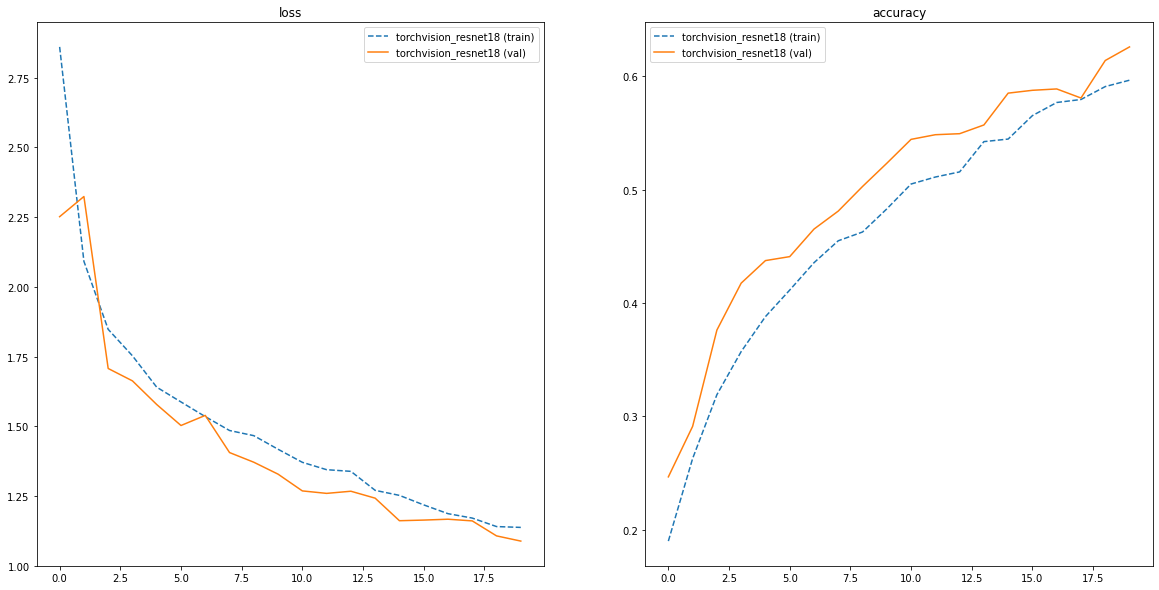

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
label = 'torchvision_resnet18'
axes[0].set_title('loss')
axes[0].plot(train_losses, '--', label=f"{label} (train)")
axes[0].plot(val_losses, label=f"{label} (val)")
axes[0].legend()
axes[1].set_title('accuracy')
axes[1].plot(train_accuracy, '--', label=f"{label} (train)")
axes[1].plot(val_accuracy, label=f"{label} (val)")
axes[1].legend()

plt.show()

The ResNet18 architecture is learning the classification quite well. If we were to let it train for a larger number of epochs and perform some learning rate scheduling, it would get good results on CIFAR-10. But the ResNet18 architecture is actually designed for bigger input images and thus oversized for CIFAR-10 images. In the next notebook, we will thus implement an adapted ResNet structure, which is better suited for the small 32x32 CIFAR-10 images.

## Visualizing results

We can also visualize the predictions of the network on the validation set. Note that now we have to use the softmax operation on the model's results, if we want to obtain classification probabilities.

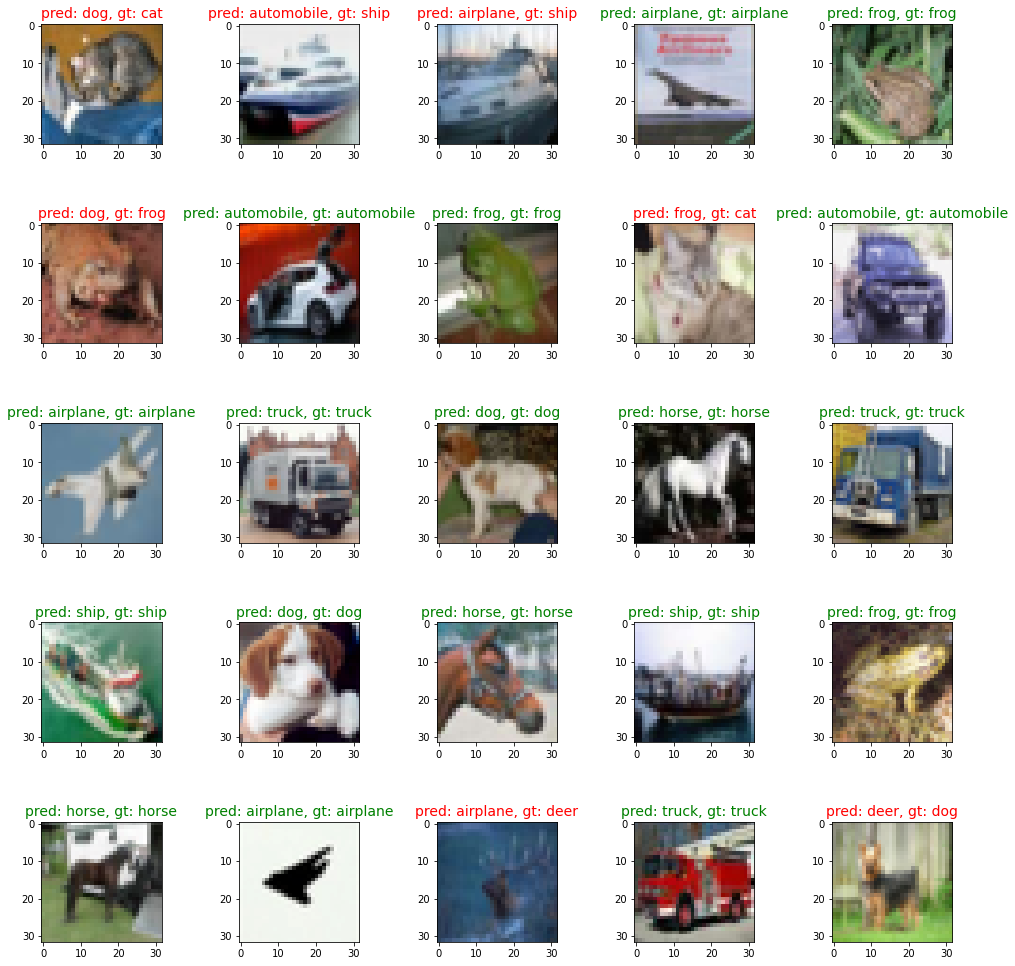

In [15]:
from torchvision.transforms.functional import to_pil_image
from math import ceil

num_test_samples = 25
images, labels = next(val_loader.__iter__())

num_cols = 5
num_rows = int(ceil(num_test_samples/num_cols))
fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, 14))

model.eval()
predictions = model(images.to(device))
scores = nn.functional.softmax(predictions, dim=-1)
predicted_classes = torch.argmax(scores, dim=-1)
# actually if we only need the index of the class with the highest probability, we could omit the softmax operation and perform argmax on the logits directly.
# predicted_classes = torch.argmax(predictions, dim=-1)

for i in range(num_test_samples):
    image, label = images[i], labels[i]
    predicted_class = predicted_classes[i].cpu().item()
    
    # undo image normalization
    for channel in range(3):
        image[channel] *= normalize_std[channel]
        image[channel] += normalize_mean[channel]
    # transform tensor back to a PIL image
    image = to_pil_image(image)
    
    ax = axes[i//num_cols, i%num_cols]
    ax.imshow(image)
    ax.set_title(f"pred: {classes[predicted_class]}, gt: {classes[label]}", fontdict={"fontsize": 14, "color": ("green" if predicted_class == label else "red")})
plt.tight_layout()
plt.show()